<a href="https://colab.research.google.com/github/taiki323/kaggle_training/blob/master/Porto_Seguro%E2%80%99s_Safe_Driver_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 課題
車のドライバーの情報から、その人が次の年に保険金請求するかどうかを予想。    
0なら請求無し、1なら請求有り。   
2クラス分類。

Submission File   
id,target   
0,0.1   
1,0.9   
2,1.0   
etc.   


# セットアップ

In [1]:
!pip install kaggle
!pip install lightgbm
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

    100% |████████████████████████████████| 61kB 3.9MB/s 
    100% |████████████████████████████████| 235kB 6.7MB/s 
  Running setup.py bdist_wheel for kaggle ... - done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify
    100% |████████████████████████████████| 1.2MB 8.1MB/s 
Download 100%.


In [2]:
import pandas as pd
import numpy as np
import datetime
import re
import sklearn, scipy
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from time import sleep
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# !mkdir .kaggle
!mkdir ~/.kaggle
%cd /content
!mkdir work
%cd work
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

/content
/content/work


In [0]:
!kaggle competitions download -c porto-seguro-safe-driver-prediction
!apt-get install p7zip-full
!7z x '*.7z'

# 前処理

## データ
ind、reg、car、calcでタグ付けされている。59カラム   
-1の値は欠落データ   
catはカテゴリ変数。整数   
binはバイナリ変数。0か1   
他は整数か浮動小数点値



In [0]:
train = pd.read_csv("/content/gdrive/My Drive/kaggle/Porto_Seguro’s_Safe_Driver_Prediction/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/kaggle/Porto_Seguro’s_Safe_Driver_Prediction/test.csv")

In [7]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [8]:
train.shape, test.shape

((595212, 59), (892816, 58))

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [0]:
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type 
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [11]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [12]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [13]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


In [14]:
#浮動小数点値の変数
v = meta[(meta['level'] == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


reg   
- reg03にのみ欠損値あり   
- 最大値がバラバラ   

car   
- car12とcar14に欠損値あり
- 最大値がバラバラ

calc
- 欠損値なし
- 最小値と最大値が全て同じ
- 標準偏差がどれもほぼ同じ



In [15]:
# 整数の変数
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


ps_car_11にのみ欠損値あり

In [16]:
# バイナリの変数
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
train[v]['target'].value_counts()

0    573518
1     21694
Name: target, dtype: int64

targetは0が多く、1が少ない不均衡データ

## 不均衡データのアンダーサンプリング

In [18]:
desired_apriori=0.10

idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# データ数
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

idx_list = list(undersampled_idx) + list(idx_1)

train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [19]:
train.shape[0], train[train["target"] == 0].shape[0], train[train["target"] == 1].shape[0]

(216940, 195246, 21694)

## 欠損値

In [20]:
all_num = train.shape[0]

for f in train.columns:
  lost_num = len(train[train[f] == -1])
  if lost_num > 0 :
    loss_per = round((lost_num / all_num) * 100, 2)
    print("{0} is lost {1} data  {2}%".format(f, lost_num, loss_per))

ps_ind_02_cat is lost 103 data  0.05%
ps_ind_04_cat is lost 51 data  0.02%
ps_ind_05_cat is lost 2256 data  1.04%
ps_reg_03 is lost 38580 data  17.78%
ps_car_01_cat is lost 62 data  0.03%
ps_car_02_cat is lost 2 data  0.0%
ps_car_03_cat is lost 148367 data  68.39%
ps_car_05_cat is lost 96026 data  44.26%
ps_car_07_cat is lost 4431 data  2.04%
ps_car_09_cat is lost 230 data  0.11%
ps_car_11 is lost 1 data  0.0%
ps_car_14 is lost 15726 data  7.25%


ps_car_03_catとps_car_05_catは欠損率が高いので、カラムを削除

In [0]:
#列削除
drop_list = ["ps_car_03_cat", "ps_car_05_cat"]

train.drop(drop_list, inplace=True, axis=1)
meta.loc[(drop_list),'keep'] = False

In [0]:
mean_imp = Imputer(missing_values=-1, strategy='mean', axis=0)
mode_imp = Imputer(missing_values=-1, strategy='most_frequent', axis=0)

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

## カテゴリ変数

In [23]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
  cat_num = train[f].value_counts().shape[0]
  print("{0} has {1} category".format(f, cat_num))


ps_ind_02_cat has 5 category
ps_ind_04_cat has 3 category
ps_ind_05_cat has 8 category
ps_car_01_cat has 13 category
ps_car_02_cat has 3 category
ps_car_04_cat has 10 category
ps_car_06_cat has 18 category
ps_car_07_cat has 3 category
ps_car_08_cat has 2 category
ps_car_09_cat has 6 category
ps_car_10_cat has 3 category
ps_car_11_cat has 104 category


In [0]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [0]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

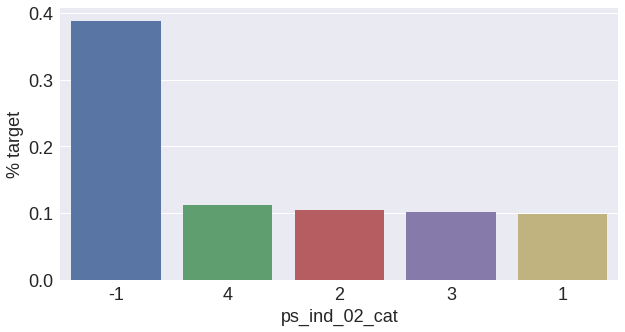

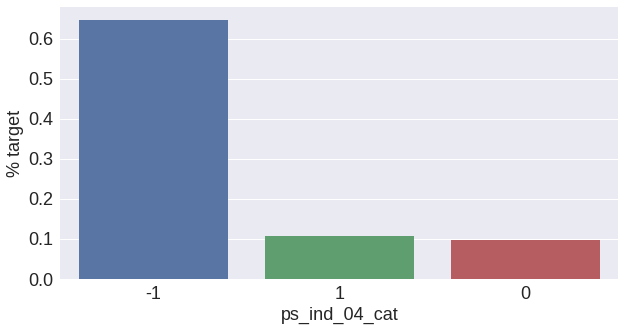

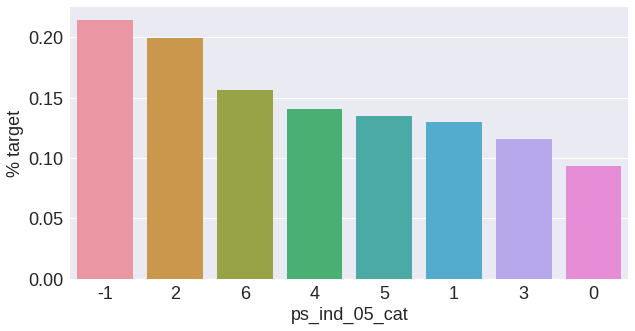

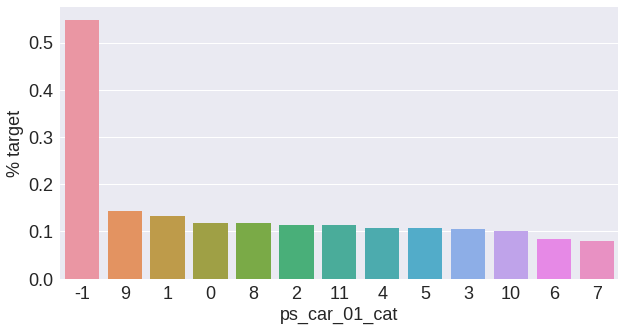

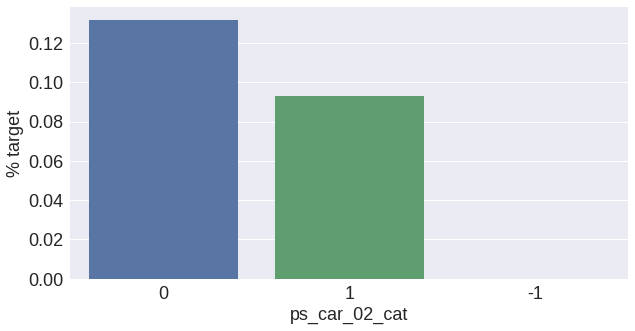

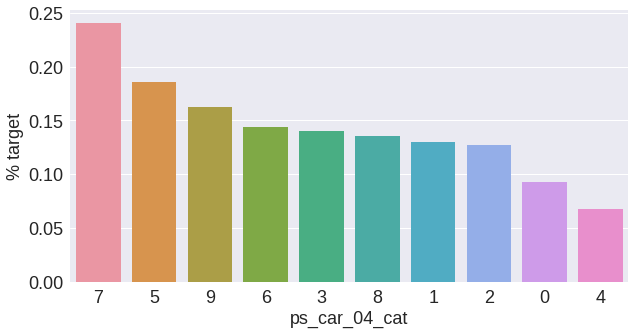

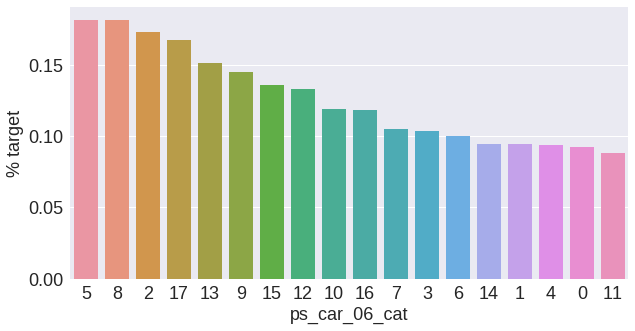

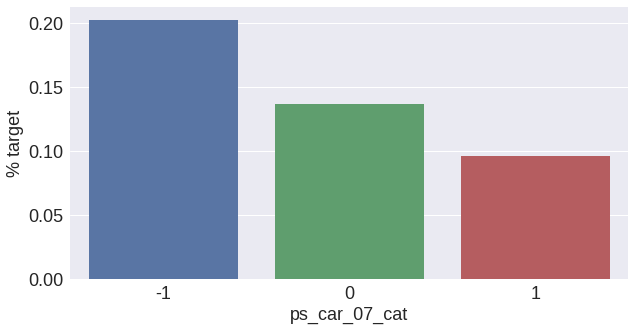

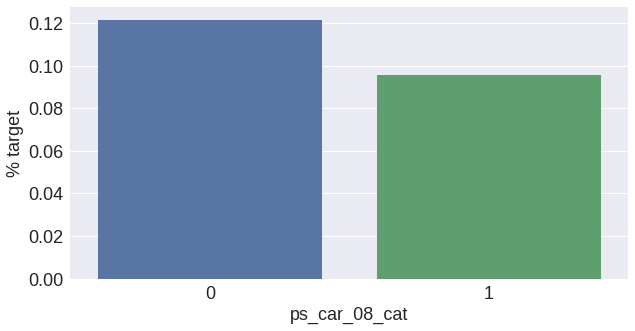

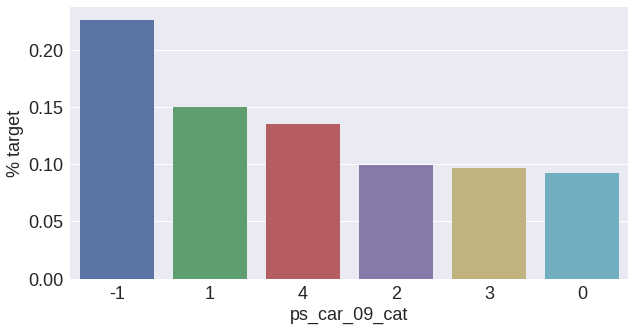

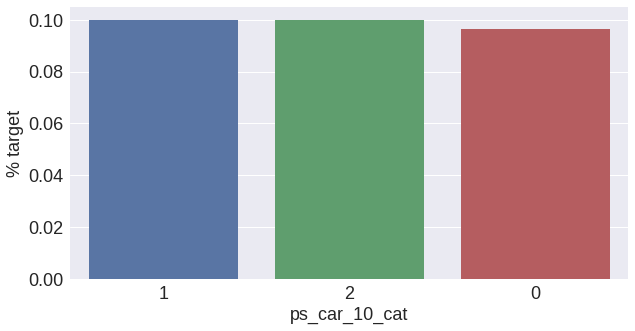

In [49]:
# 各カテゴリのtargetに対する割合
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

欠損値を持つ顧客は保険の利用率が高いので、
欠損値をmodeで補完せずに別のカテゴリとして保持。

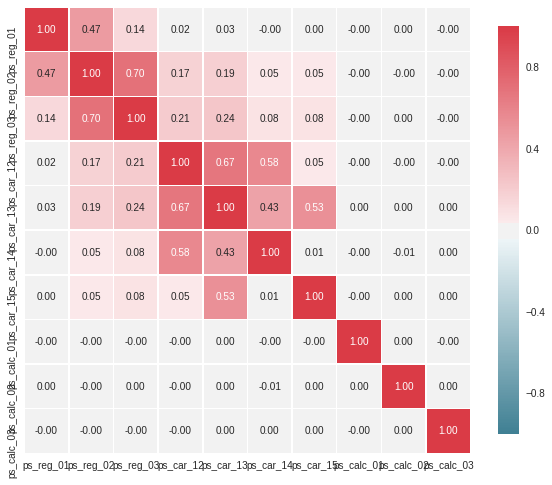

In [50]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

In [0]:
s = train.sample(frac=0.1)

In [46]:
while 1:
  sleep(10)

KeyboardInterrupt: ignored